# Predictions by year

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import RocCurveDisplay

In [7]:
df = pd.read_csv('db_criminalBehaviour_byYear.csv')
df.drop(['categories', 'Unnamed: 0', 'index'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            581 non-null    int64 
 1   problem_type_1  581 non-null    object
 2   count           581 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 13.7+ KB


In [8]:
df

,year,problem_type_1,count
0,2009,Abandonment/nonsupport of incompetent person,14
1,2009,Abuse of incapacitated persons,2
2,2009,Agression,297
3,2009,Break-in,924
4,2009,Child grooming/enticement,2
...,...,...,...
576,2022,Stalking,2
577,2022,Theft,1037
578,2022,"Theft, loss, recovery, seizure of firearms",5
579,2022,Violation of Protective Measures for women - L...,835


In [10]:
target = df['count']
train_data = df.drop(['count'], axis=1)

In [11]:
num_features = ['year']
cat_features = ['problem_type_1']

In [12]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=4)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

In [15]:
models2test = [
    SVR(),
    DecisionTreeRegressor(max_depth=2, random_state=4392),
    ExtraTreesRegressor(n_estimators=100, random_state=4392),
    GradientBoostingRegressor(random_state=4392),
]

In [29]:
scores_classif = {}
for classifier in models2test:
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])


    crossVal = TimeSeriesSplit(n_splits=5)
    scores = cross_validate(pipeline, train_data, target, cv=crossVal,
                            scoring=('r2', 'neg_mean_absolute_error', 'explained_variance'),
                            return_train_score=True, return_estimator=True, return_indices=True) 
    
    print('\n')
    print('-----------------------------------')
    print(str(classifier))
    print('-----------------------------------')

    print('\n')
    print('train_r2 mean: ',scores['train_r2'].mean())
    print('train_r2 std: ',scores['train_r2'].std())
    print('test_r2 mean: ',scores['test_r2'].mean())
    print('test_r2 std: ',scores['test_r2'].std())

    print('\n')
    print('train_neg_mean_absolute_error mean: ',scores['train_neg_mean_absolute_error'].mean())
    print('train_neg_mean_absolute_error std: ',scores['train_neg_mean_absolute_error'].std())
    print('test_neg_mean_absolute_error mean: ',scores['test_neg_mean_absolute_error'].mean())
    print('test_neg_mean_absolute_error std: ',scores['test_neg_mean_absolute_error'].std())

    print('\n')
    print('train_explained_variance mean: ',scores['train_explained_variance'].mean())
    print('train_explained_variance std: ',scores['train_explained_variance'].std())
    print('test_explained_variance mean: ',scores['test_explained_variance'].mean())
    print('test_explained_variance std: ',scores['test_explained_variance'].std())

    clf_txt = str(classifier).split('(')[0]
    scores_classif[clf_txt] = scores



-----------------------------------
SVR()
-----------------------------------


train_r2 mean:  -0.12885852665947978
train_r2 std:  0.01270878726761537
test_r2 mean:  -0.15729661869558723
test_r2 std:  0.022201659794670543


train_neg_mean_absolute_error mean:  -124.01464702342594
train_neg_mean_absolute_error std:  23.124239464289413
test_neg_mean_absolute_error mean:  -166.26401883146582
test_neg_mean_absolute_error std:  10.266530286924501


train_explained_variance mean:  0.005306569071172884
train_explained_variance std:  0.0015415010255727705
test_explained_variance mean:  0.0018999033547075328
test_explained_variance std:  0.0014639547793474646


-----------------------------------
DecisionTreeRegressor(max_depth=2, random_state=4392)
-----------------------------------


train_r2 mean:  0.6592272034222322
train_r2 std:  0.06344617695058202
test_r2 mean:  0.42915023347355186
test_r2 std:  0.15565398061217978


train_neg_mean_absolute_error mean:  -110.30393540668922
train_neg_

Here I check the cross-validation for the extra trees regressor and the gradient boosting:

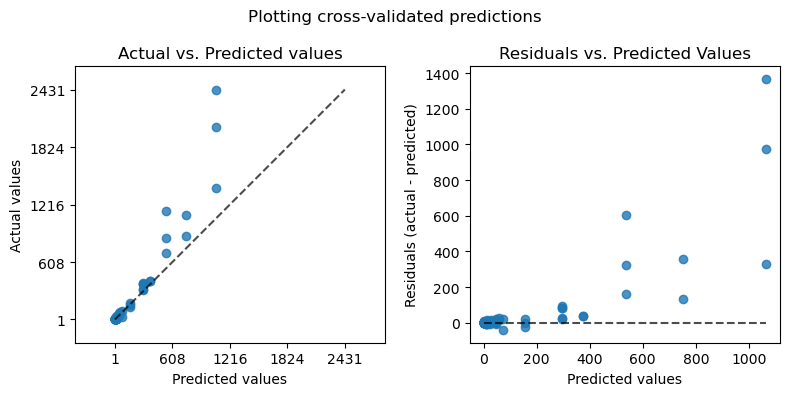

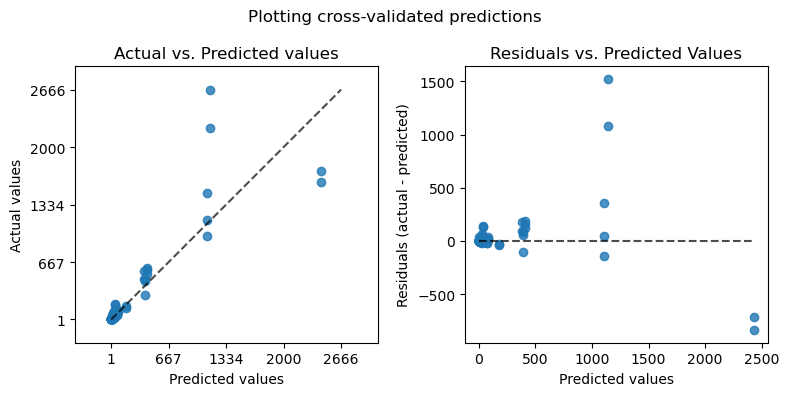

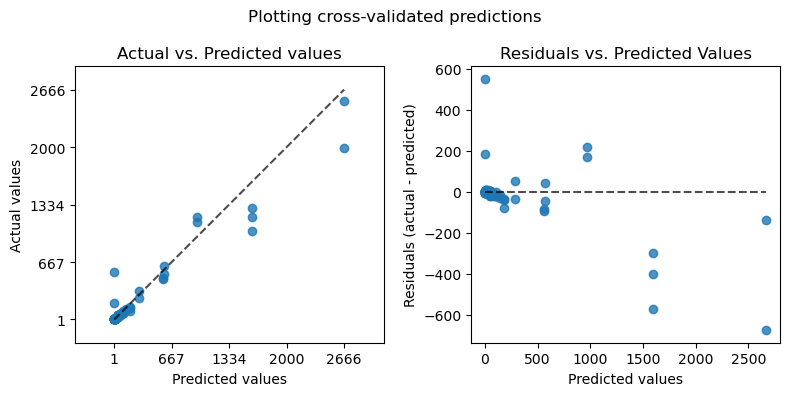

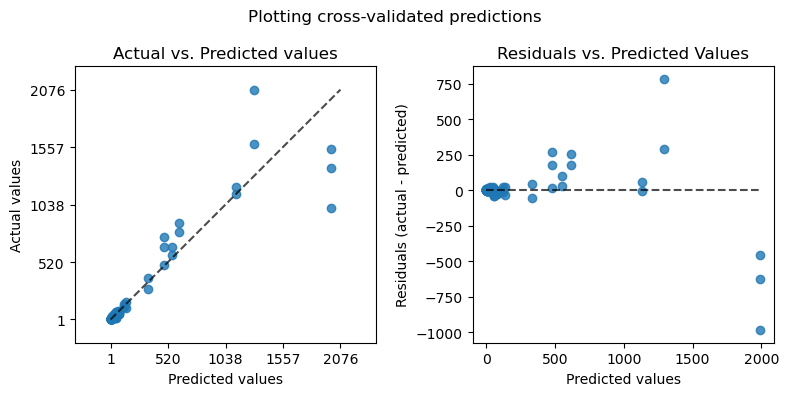

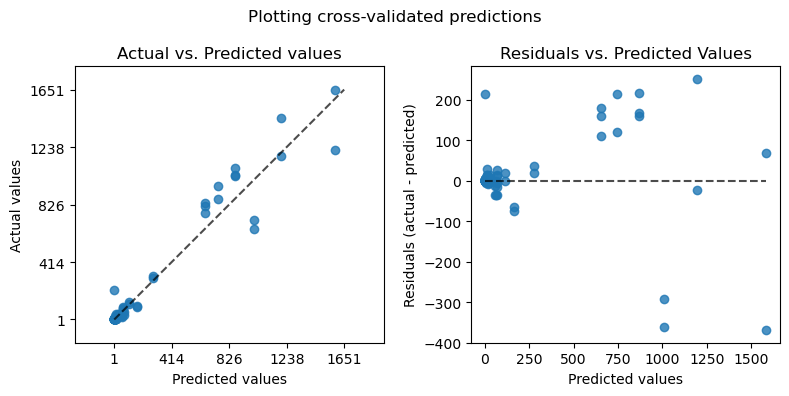

In [51]:
for idx,clf in enumerate(scores_classif['ExtraTreesRegressor']['estimator']):
    idx_train = scores_classif['ExtraTreesRegressor']['indices']['train'][idx]
    idx_test  = scores_classif['ExtraTreesRegressor']['indices']['test'][idx]

    X_train = train_data.loc[idx_train,:]
    y_train = target.loc[idx_train]
    X_test  = train_data.loc[idx_test,:]
    y_test  = target.loc[idx_test]

    y_pred = clf.fit(X_train,y_train).predict(X_test)

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions")
    plt.tight_layout()
    plt.show()

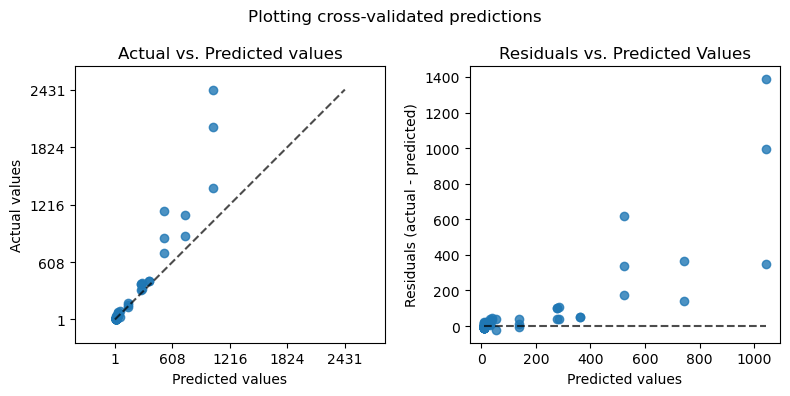

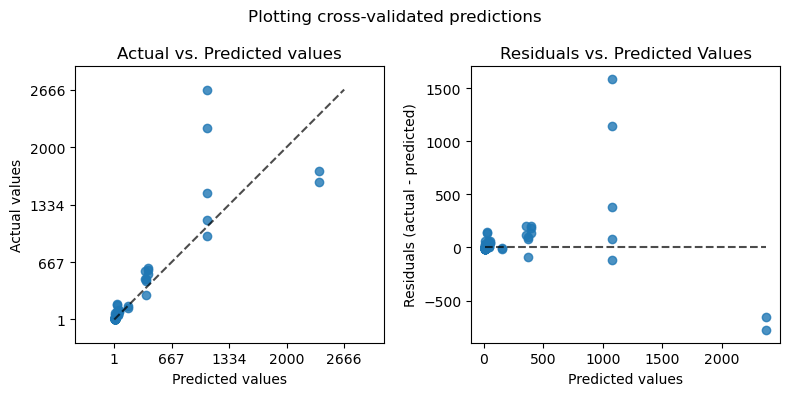

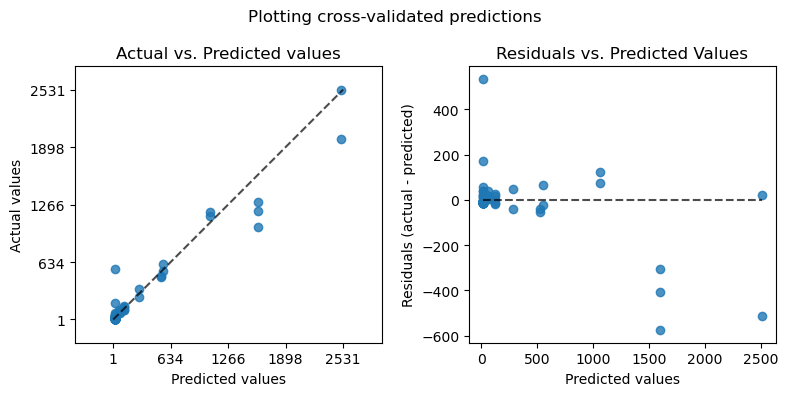

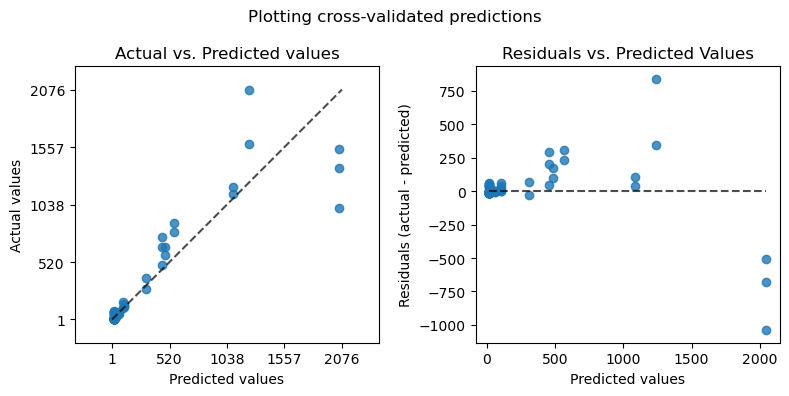

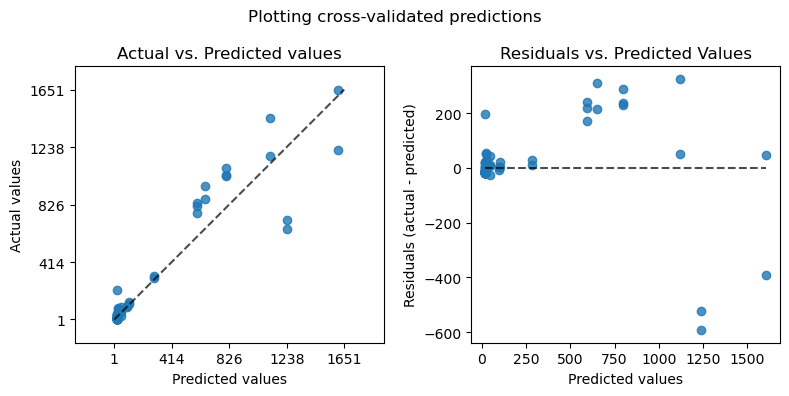

In [50]:
for idx,clf in enumerate(scores_classif['GradientBoostingRegressor']['estimator']):
    idx_train = scores_classif['GradientBoostingRegressor']['indices']['train'][idx]
    idx_test  = scores_classif['GradientBoostingRegressor']['indices']['test'][idx]

    X_train = train_data.loc[idx_train,:]
    y_train = target.loc[idx_train]
    X_test  = train_data.loc[idx_test,:]
    y_test  = target.loc[idx_test]

    y_pred = clf.fit(X_train,y_train).predict(X_test)

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions")
    plt.tight_layout()
    plt.show()